# Final Project

This notebook is adapted from here: https://aiqm.github.io/torchani/examples/nnp_training.html

## Checkpoint 1: Data preparation

1. Create a working directory: `/global/scratch/users/[USER_NAME]/[DIR_NAME]`. Replace the [USER_NAME] with yours and specify a [DIR_NAME] you like.
2. Copy this Jupyter Notebook to the working directory
3. Download the ANI dataset `ani_dataset_gdb_s01_to_s04.h5` from bCourses and upload it to the working directory
4. Complete this notebook (can be worked on with your laptop, but **must be run on the cluster** for the final outputs)

Hint: You can use ? to learn more about any python function, e.g. ?torch.nn.Linear

In [55]:
!pwd

/Users/chu/Documents/Class/MSSE_Spring2024/Chem277B/Final_Project


In [56]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torchani
import torchani.data
import matplotlib.pyplot as plt
import time

### Use GPU

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


Savio Cluster!

In [ ]:
# Now running on SAVIO Cluster!

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


### Set up AEV computer

#### AEV: Atomic Environment Vector (atomic features)

Ref: Chem. Sci., 2017, 8, 3192

In [6]:
def init_aev_computer():
    Rcr = 5.2
    Rca = 3.5
    EtaR = torch.tensor([16], dtype=torch.float, device=device)
    ShfR = torch.tensor([
        0.900000, 1.168750, 1.437500, 1.706250, 
        1.975000, 2.243750, 2.512500, 2.781250, 
        3.050000, 3.318750, 3.587500, 3.856250, 
        4.125000, 4.393750, 4.662500, 4.931250
    ], dtype=torch.float, device=device)


    EtaA = torch.tensor([8], dtype=torch.float, device=device)
    Zeta = torch.tensor([32], dtype=torch.float, device=device)
    ShfA = torch.tensor([0.90, 1.55, 2.20, 2.85], dtype=torch.float, device=device)
    ShfZ = torch.tensor([
        0.19634954, 0.58904862, 0.9817477, 1.37444680, 
        1.76714590, 2.15984490, 2.5525440, 2.94524300
    ], dtype=torch.float, device=device)

    num_species = 4
    aev_computer = torchani.AEVComputer(
        Rcr, Rca, EtaR, ShfR, EtaA, Zeta, ShfA, ShfZ, num_species
    )
    return aev_computer

aev_computer = init_aev_computer()
aev_dim = aev_computer.aev_length
print(aev_dim)

384


### Prepare dataset & split

In [7]:
def load_ani_dataset(dspath):
    self_energies = torch.tensor([
        0.500607632585, -37.8302333826,
        -54.5680045287, -75.0362229210
    ], dtype=torch.float, device=device)
    energy_shifter = torchani.utils.EnergyShifter(None)
    species_order = ['H', 'C', 'N', 'O']

    dataset = torchani.data.load(dspath)
    dataset = dataset.subtract_self_energies(energy_shifter, species_order)
    dataset = dataset.species_to_indices(species_order)
    dataset = dataset.shuffle()
    return dataset

dataset = load_ani_dataset("ani_gdb_s01_to_s04.h5")

In [8]:
# Use dataset.split method to do split
train_data, val_data, test_data = dataset.split(0.8, 0.1, None)

# Show amount of training data vs total data
print("Training data size:", len(train_data))
print("Validation data size:", len(val_data))
print("Test data size:", len(test_data))
print("Total data size:", len(dataset))
# assert(len(dataset) == len(val_data) + len(test_data) + len(train_data))
print(691918 + 86489 * 2)

Training data size: 691918
Validation data size: 86489
Test data size: 86491
Total data size: 864898
864896


### Batching

In [9]:
batch_size = 8192
# use dataset.collate(...).cache() method to do batching

train_data_loader = train_data.collate(batch_size).cache()
val_data_loader = val_data.collate(batch_size).cache()
test_data_loader = test_data.collate(batch_size).cache()

In [10]:
# Show that batching is working correctly
train_data_loader_list = list(train_data_loader)
train_data_loader_list

[defaultdict(list,
             {'species': tensor([[ 3,  1,  1,  ..., -1, -1, -1],
                      [ 1,  1,  3,  ..., -1, -1, -1],
                      [ 1,  1,  1,  ...,  0, -1, -1],
                      ...,
                      [ 2,  1,  1,  ..., -1, -1, -1],
                      [ 1,  1,  2,  ..., -1, -1, -1],
                      [ 1,  2,  1,  ..., -1, -1, -1]]),
              'coordinates': tensor([[[-1.5999, -0.4062, -0.0124],
                       [-0.7064,  0.4160,  0.0160],
                       [ 0.7677,  0.0525,  0.0529],
                       ...,
                       [ 0.0000,  0.0000,  0.0000],
                       [ 0.0000,  0.0000,  0.0000],
                       [ 0.0000,  0.0000,  0.0000]],
              
                      [[-1.4458, -0.1018, -0.0073],
                       [ 0.0720,  0.1440,  0.0530],
                       [ 0.8097, -1.0507,  0.0073],
                       ...,
                       [ 0.0000,  0.0000,  0.0000],
          

In [11]:
print(len(train_data_loader_list))
assert(len(train_data_loader_list) == len(train_data) // batch_size + 1)

85


The appropriate number of batches were created. For a dataset of size 691918, a total of 85 batches should be created and that is what is observed

In [12]:
display(len(train_data_loader_list[0]['species']))
display(len(train_data_loader_list[0]['coordinates']))
display(len(train_data_loader_list[0]['energies']))

8192

8192

8192

Batching is appropriately creating batches of size 8192. Each batch of the ANI dataset is of a dictionary with species, coordinates, and energies all stored in corresponding tensors.

In [13]:
# Training Data Batches
for i, batch in enumerate(train_data_loader):
    species = batch['species']
    print(f'Batch # {i} is of size: { len(species) }')

Batch # 0 is of size: 8192
Batch # 1 is of size: 8192
Batch # 2 is of size: 8192
Batch # 3 is of size: 8192
Batch # 4 is of size: 8192
Batch # 5 is of size: 8192
Batch # 6 is of size: 8192
Batch # 7 is of size: 8192
Batch # 8 is of size: 8192
Batch # 9 is of size: 8192
Batch # 10 is of size: 8192
Batch # 11 is of size: 8192
Batch # 12 is of size: 8192
Batch # 13 is of size: 8192
Batch # 14 is of size: 8192
Batch # 15 is of size: 8192
Batch # 16 is of size: 8192
Batch # 17 is of size: 8192
Batch # 18 is of size: 8192
Batch # 19 is of size: 8192
Batch # 20 is of size: 8192
Batch # 21 is of size: 8192
Batch # 22 is of size: 8192
Batch # 23 is of size: 8192
Batch # 24 is of size: 8192
Batch # 25 is of size: 8192
Batch # 26 is of size: 8192
Batch # 27 is of size: 8192
Batch # 28 is of size: 8192
Batch # 29 is of size: 8192
Batch # 30 is of size: 8192
Batch # 31 is of size: 8192
Batch # 32 is of size: 8192
Batch # 33 is of size: 8192
Batch # 34 is of size: 8192
Batch # 35 is of size: 8192
Ba

In [14]:
# Test Data Batches
for i, batch in enumerate(test_data_loader):
    species = batch['species']
    print(f'Batch # {i} is of size: { len(species) }')

Batch # 0 is of size: 8192
Batch # 1 is of size: 8192
Batch # 2 is of size: 8192
Batch # 3 is of size: 8192
Batch # 4 is of size: 8192
Batch # 5 is of size: 8192
Batch # 6 is of size: 8192
Batch # 7 is of size: 8192
Batch # 8 is of size: 8192
Batch # 9 is of size: 8192
Batch # 10 is of size: 4571


In [15]:
# Val Data Batches
for i, batch in enumerate(val_data_loader):
    species = batch['species']
    print(f'Batch # {i} is of size: { len(species) }')

Batch # 0 is of size: 8192
Batch # 1 is of size: 8192
Batch # 2 is of size: 8192
Batch # 3 is of size: 8192
Batch # 4 is of size: 8192
Batch # 5 is of size: 8192
Batch # 6 is of size: 8192
Batch # 7 is of size: 8192
Batch # 8 is of size: 8192
Batch # 9 is of size: 8192
Batch # 10 is of size: 4569


All the batching works well! Appropriate number of batches all of size 8192 except for the last batch were created

### Torchani API

In [16]:
class AtomicNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(384, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

net_H = AtomicNet()
net_C = AtomicNet()
net_N = AtomicNet()
net_O = AtomicNet()

# ANI model requires a network for each atom type
# use torchani.ANIModel() to compile atomic networks
ani_net = torchani.ANIModel([net_H, net_C, net_N, net_O])
model = nn.Sequential(
    aev_computer,
    ani_net
).to(device)

In [17]:
train_data_batch = next(iter(train_data_loader))

loss_func = nn.MSELoss()
species = train_data_batch['species'].to(device)
coords = train_data_batch['coordinates'].to(device)
true_energies = train_data_batch['energies'].to(device).float()
_, pred_energies = model((species, coords))
loss = loss_func(true_energies, pred_energies)
print(loss)

tensor(0.6527, grad_fn=<MseLossBackward0>)


# Checkpoint 2

In [50]:
def timeit(f):
    def timed(*args, **kw):
        ts = time.time()
        result = f(*args, **kw)
        te = time.time()
        print(f'func: {f.__name__} took: {te-ts:.4f} sec on {device}')
        return result
    return timed

class ANITrainer:
    def __init__(self, model, batch_size, learning_rate, epoch, l2):
        self.model = model
        
        num_params = sum(item.numel() for item in model.parameters())
        print(f"{model.__class__.__name__} - Number of parameters: {num_params}")
        
        self.batch_size = batch_size
        self.optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=l2)
        self.epoch = epoch
        # definition of loss function: MSE is a good choice! 
        self.loss_function = nn.MSELoss()
    
    @timeit
    def train(self, train_data, val_data, 
              early_stop=True, draw_curve=True, verbose=True):
        self.model.train()
        
        # init data loader
        print("Initialize training data...")
        train_data_loader = train_data.collate(batch_size).cache()
        
        # record epoch losses
        train_loss_list = []
        val_loss_list = []
        lowest_val_loss = np.inf
        
        if verbose:
            iterator = range(self.epoch)
        else:
            iterator = tqdm(range(self.epoch), leave=True)
        
        for i in iterator:
            train_epoch_loss = 0.0
            for train_data_batch in train_data_loader:
                
                species = train_data_batch['species'].to(device)
                coords = train_data_batch['coordinates'].to(device)
                true_energies = train_data_batch['energies'].to(device).float()

                # compute energies
                _, pred_energies = self.model((species, coords))
                
                # compute loss
                # loss = loss_func(true_energies, pred_energies)
                batch_loss = self.loss_function(true_energies, pred_energies)
                
                # do a step
                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()
                
                batch_importance = train_data_batch['species'].shape[0] / len(train_data)
                train_epoch_loss += batch_loss.detach().cpu().item() * batch_importance
            
            # use the self.evaluate to get loss/MAE/RMSE on the validation set 
            val_epoch_loss, mae, rmse = self.evaluate(val_data)
            
            # append the losses
            train_loss_list.append(train_epoch_loss)
            val_loss_list.append(val_epoch_loss)
            
            if early_stop:
                if val_epoch_loss < lowest_val_loss:
                    lowest_val_loss = val_epoch_loss
                    weights = self.model.state_dict()
        
        if draw_curve:
            # Plot train loss and validation loss
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            # If you used MSELoss above to compute the loss
            # Calculate the RMSE for plotting
            x_axis = np.arange(self.epoch)
            train_loss_rmse = np.sqrt(train_loss_list)
            val_loss_rmse = np.sqrt(val_loss_list)
            ax.plot(x_axis, train_loss_rmse, label='Train Loss (RMSE)')
            ax.plot(x_axis, val_loss_rmse, label='Validation Loss (RMSE)')
            # ax.plot(np.arange(len(train_loss_rmse))+1, train_loss_rmse, label='Train Loss (RMSE)')
            # ax.plot(np.arange(len(val_loss_rmse))+1, val_loss_rmse, label='Validation Loss (RMSE)')
            ax.legend()
            ax.set_xlabel("Epoch")
            ax.set_ylabel("RMSE")
        
        if early_stop:
            self.model.load_state_dict(weights)
        
        return train_loss_list, val_loss_list
    
    
    def evaluate(self, data, draw_plot=False):
        
        # init data loader
        data_loader = data.collate(batch_size).cache()
        total_loss = 0.0
        
        # init energies containers
        true_energies_all = []
        pred_energies_all = []
            
        with torch.no_grad():
            for batch_data in data_loader:
                
                # compute energies
                species = batch_data['species'].to(device)
                coords = batch_data['coordinates'].to(device)
                true_energies = batch_data['energies'].to(device).float()

                # compute energies
                _, pred_energies = self.model((species, coords))
                
                # compute loss
                batch_loss = self.loss_function(true_energies, pred_energies)

                batch_importance = batch_data['species'].shape[0] / len(data)
                total_loss += batch_loss.detach().cpu().item() * batch_importance
                
                # store true and predicted energies
                true_energies_all.append(true_energies.detach().cpu().numpy().flatten())
                pred_energies_all.append(pred_energies.detach().cpu().numpy().flatten())
        true_energies_all = np.concatenate(true_energies_all)
        pred_energies_all = np.concatenate(pred_energies_all)

        # Report the mean absolute error (MAE) and root mean square error (RMSE)
        # The unit of energies in the dataset is hartree
        # please convert it to kcal/mol when reporting
        # 1 hartree = 627.5094738898777 kcal/mol
        # MAE = mean(|true - pred|)
        # RMSE = sqrt(mean( (true-pred)^2 ))
        hartree2kcalmol = 627.5094738898777
        mae = np.mean(np.abs(true_energies_all - pred_energies_all)) * hartree2kcalmol
        rmse = np.sqrt(mae)

        if draw_plot:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.scatter(true_energies_all, pred_energies_all, label=f"MAE: {mae:.2f} kcal/mol, RMSE: {rmse:.2f} kcal/mol", s=2)
            ax.set_xlabel("Ground Truth")
            ax.set_ylabel("Predicted")
            xmin, xmax = ax.get_xlim()
            ymin, ymax = ax.get_ylim()
            vmin, vmax = min(xmin, ymin), max(xmax, ymax)
            ax.set_xlim(vmin, vmax)
            ax.set_ylim(vmin, vmax)
            ax.plot([vmin, vmax], [vmin, vmax], color='red')
            ax.legend()
            
        return total_loss, mae, rmse

## 1 heavy atom

Train/Total: 8640/10800
Sequential - Number of parameters: 197636


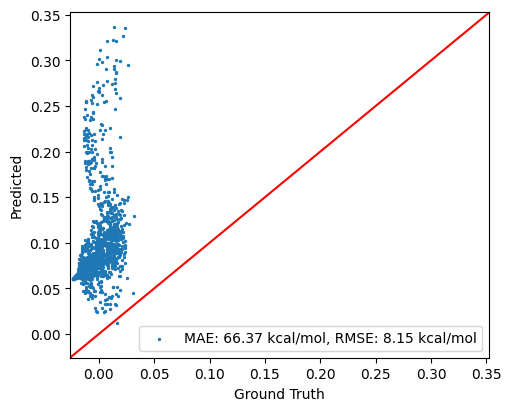

In [51]:
# Load dataset with 1 heavy atom
# Then do a train/val/test = 80/10/10 split
dataset = load_ani_dataset("ani_gdb_s01.h5")
train_data, val_data, test_data = dataset.split(0.8, 0.1, 0.1)
print(f'Train/Total: {len(train_data)}/{len(dataset)}')

# Define the model
model = nn.Sequential(
    aev_computer,
    ani_net
).to(device)

# Initiate the trainer and evaluate on test_dataset with draw_plot=True
trainer = ANITrainer(model=model, batch_size=8192, learning_rate=1e-3, epoch=20, l2=1e-5)
loss, mae, rmse = trainer.evaluate(test_data, draw_plot=True)

Initialize training data...
func: train took: 3.3006 sec on cpu


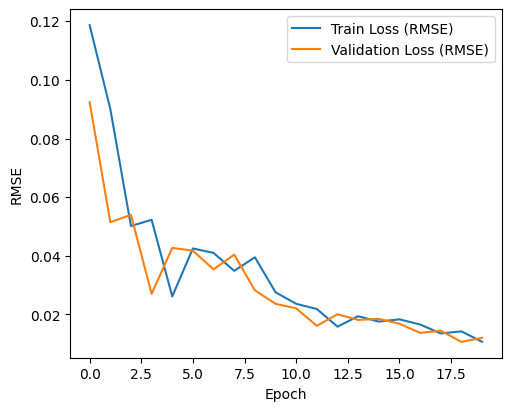

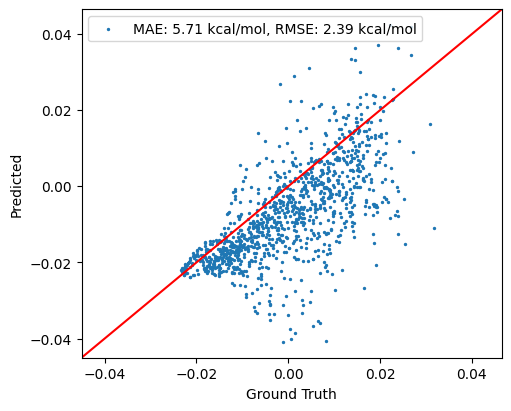

In [52]:
# Run on CPU
# Perform training and re-evaluate on test_dataset with draw_plot=True
train_losses, val_losses = trainer.train(train_data, val_data, verbose=True)
loss, mae, rmse = trainer.evaluate(test_data, draw_plot=True)

In [ ]:
# Run on GPU
# Perform training and re-evaluate on test_dataset with draw_plot=True
train_losses, val_losses = trainer.train(train_data, val_data, verbose=True)
loss, mae, rmse = trainer.evaluate(test_data, draw_plot=True)

## n heavy atoms

Train/Total: 40769/50962
Sequential - Number of parameters: 197636


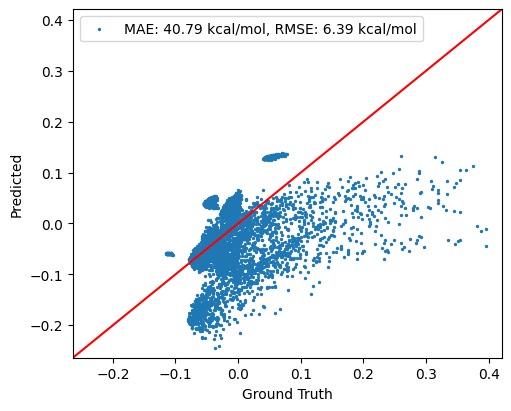

In [53]:
# Load dataset with n (different from 1) heavy atom
# Then do a train/val/test = 80/10/10 split
dataset = load_ani_dataset("ani_gdb_s02.h5")
train_data, val_data, test_data = dataset.split(0.8, 0.1, 0.1)
print(f'Train/Total: {len(train_data)}/{len(dataset)}')

# Define the model
model = nn.Sequential(
    aev_computer,
    ani_net
).to(device)

# Initiate the trainer and evaluate on test_dataset with draw_plot=True
trainer = ANITrainer(model=model, batch_size=8192, learning_rate=1e-3, epoch=20, l2=1e-5)
loss, mae, rmse = trainer.evaluate(test_data, draw_plot=True)

Initialize training data...
func: train took: 18.0796 sec on cpu


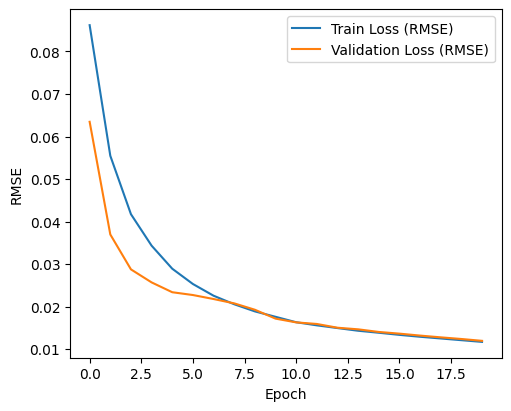

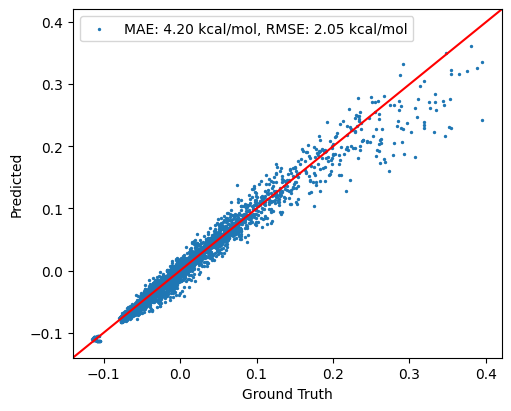

In [54]:
# Run on CPU
# Perform training and re-evaluate on test_dataset with draw_plot=True
train_losses, val_losses = trainer.train(train_data, val_data, verbose=True)
loss, mae, rmse = trainer.evaluate(test_data, draw_plot=True)

In [ ]:
# Run on GPU
# Perform training and re-evaluate on test_dataset with draw_plot=True
train_losses, val_losses = trainer.train(train_data, val_data, verbose=True)
loss, mae, rmse = trainer.evaluate(test_data, draw_plot=True)